In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib

from mesa.batchrunner import BatchRunner

import src.model

In [2]:
# run this cell to re-import the Model class
importlib.reload(src.model);

# Single run

In [3]:
# setup parameters
time_step = 0.1
n_steps = 1000

model = src.model.Model(
    length=1000,
    n_lanes=2,
    density=10,
    fraction_autonomous=0,
    max_speed_mu=120,
    max_speed_sigma=0,
    min_spacing=2,
    car_acc=33 / 10,
    car_dec=33 / 5,
    p_slowdown=0.1,
    bias_right_lane=1,
    time_step=time_step,
    seed=None,
    verbose=0)

# run simulation for `n_steps`
def run():
    for i in range(n_steps):
        model.step()
        
%time run()

CPU times: user 545 ms, sys: 23.8 ms, total: 569 ms
Wall time: 544 ms


Text(0, 0.5, 'Flow $k$')

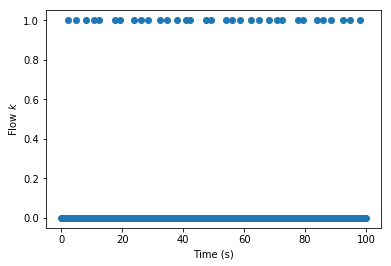

In [4]:
# plot the flow over time
df = model.data.get_model_vars_dataframe()
plt.plot(df.index * time_step, df.Flow, "o")
plt.xlabel("Time (s)")
plt.ylabel("Flow $k$")

# Batch run

Note that the `model_reporters` and `agent_reporters` of `BatchRunner` (unlike the `DataCollector`) won’t collect the data every step of the model, but only at the end of each run. Because of this the following function is used to extract the relevant data from the models datacollector.

In [5]:
def get_density(model):
    """Get the density from the model."""
    return model.density
    
def get_flow(model, initialisation_steps=0, flow_per=10):
    """Extract flow from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    flow_per -- return the flow per this number of time_steps.
    """
    # time-evolution of flow
    flows = model.data.get_model_vars_dataframe().Flow
    # return the mean
    return flows[initialisation_steps:].mean() * flow_per

In [6]:
# setup parameters
n_lanes = [1, 2]
density = np.linspace(1, 50, 10, dtype=float)
fraction_autonomous = [0]
n_steps = 1000
initialisation_steps = 500


fixed_params = {
    "length": 1000,
    "max_speed_mu": 120,
    "max_speed_sigma": 0,
    "min_spacing": 1,
    "min_distance_mu": 2,
    "min_distance_sigma": 0,
    "car_acc": 33 / 10,
    "car_dec": 33 / 5,
    "p_slowdown": 0.2,
    "bias_right_lane": 1,
    "time_step": 0.1,
    "verbose": 0
}
variable_params = {
    "n_lanes": n_lanes,
    "density": density,
    "fraction_autonomous": fraction_autonomous
}

# create and run `BatchRunner`
batch_run = BatchRunner(src.model.Model,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=2,
                        max_steps=n_steps,
                        model_reporters={
                            "density": get_density,
                            "flow": lambda x: get_flow(x, initialisation_steps)
                        },
                        agent_reporters={},
                        display_progress=True)

print("Total iterations: ", np.product([len(var) for var in batch_run.variable_parameters.values()]) * batch_run.iterations)
sys.stdout.flush()
batch_run.run_all()

Total iterations:  40


40it [00:15,  1.14it/s]


In [7]:
# get the dataframe and select the relevant columns
df = batch_run.get_model_vars_dataframe()
df = df[["density", "n_lanes", "fraction_autonomous", "flow"]]
df

,density,n_lanes,fraction_autonomous,flow
0,1.0,1,0,0.04
1,1.0,1,0,0.02
2,6.0,1,0,0.20
3,6.0,1,0,0.20
4,12.0,1,0,0.42
5,12.0,1,0,0.40
6,17.0,1,0,0.46
7,17.0,1,0,0.46
8,23.0,1,0,0.44
9,23.0,1,0,0.44


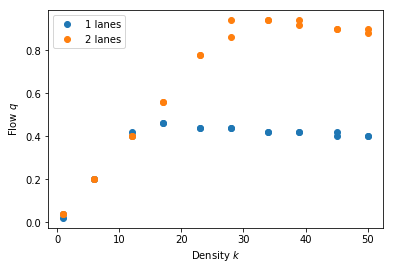

In [8]:
# plot flow rate versus vehicle density 
fig, ax = plt.subplots(1, 1)
for n_lane in n_lanes:
    data = df[df.n_lanes == n_lane]
    ax.plot(data.density, data.flow, "o", label="{} lanes".format(n_lane))

ax.set_xlabel("Density $k$")
ax.set_ylabel("Flow $q$")    
ax.legend()